In [1]:
import pandas as pd
from math import sin, cos, sqrt, atan2, radians
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate
sns.set(color_codes=True)
from sqlalchemy import create_engine
conn = create_engine("sqlite:///volcano_app/volcano.sqlite")

In [2]:
#erupt_df = pd.read_csv("clean_eruptions.csv")
#pop_df = pd.read_csv("pops.csv")
erupt_df = pd.read_sql("SELECT * FROM eruptions", conn)
# erupt_df = erupt_df.rename(columns = {"volcano_name": "Volcano Name", "start_year":"Start Year","latitude":"Latitude", "longitude":"Longitude"})
pop_df = pd.read_sql("SELECT * FROM worldcities",conn)

In [3]:
years = []
lats = []
longs = []
for name in erupt_df["volcano_name"].unique():
    temp = erupt_df[erupt_df["volcano_name"]==name]
    x = temp[temp["start_year"] == temp["start_year"].max()].iloc[0][["start_year", "latitude", "longitude"]]
    year = x[0]
    lat = x[1]
    long = x[2]
    
    years.append(year)
    lats.append(lat)
    longs.append(long)
comp_df = pd.DataFrame(data={"start_year":years, "lat":lats, "lng":longs })

In [4]:
comp_df.head()

,lat,lng,start_year
0,-77.53,167.17,1972
1,-76.28,-112.08,-5550
2,-76.05,-136.00,-8350
3,-74.35,164.70,1892
4,-74.33,-99.42,-210


In [5]:
pop_df.head()
pop_df = pop_df[["city", "lat", "lng", "pop", "country"]]
# pop_df = pop_df.rename(columns = {"city":"City", "lat":"Latitude", "lng":"Longitude", "pop":"Population", "country":"Country"})

In [6]:
def lat_long_dist(lat1,lon1,lat2,lon2):
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance   

In [7]:
years = []
dists = []
for _, pop_row in pop_df.iterrows():
    min_dist = np.inf
    min_time = 0
    for _, comp_row in comp_df.iterrows():
        dist = lat_long_dist(pop_row["lat"], pop_row["lng"], comp_row["lat"], comp_row["lng"])
        if dist < min_dist:
            min_dist = dist
            min_time = comp_row["start_year"]
    years.append(min_time)
    dists.append(min_dist)

In [8]:
pop_df['time'] = years
pop_df['time'] = 2020 - pop_df['time']
pop_df["dist"] = dists

In [9]:
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7322 entries, 0 to 7321
Data columns (total 7 columns):
city       7322 non-null object
lat        7322 non-null float64
lng        7322 non-null float64
pop        7322 non-null float64
country    7322 non-null object
time       7322 non-null float64
dist       7322 non-null float64
dtypes: float64(5), object(2)
memory usage: 400.5+ KB


In [10]:
new_df = pop_df[pop_df["pop"] > 1000 ]

In [11]:
new_df["risk"] = np.log(np.log( new_df["pop"] + 2 )/( np.log(new_df["time"] + 2)*np.square( new_df["dist"] + 2 )))

/Users/jbui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
min_thing = new_df["risk"].min()
max_thing = new_df["risk"].max()
new_df["risk"] = new_df["risk"].map(lambda x: (x-min_thing)*10/(max_thing-min_thing))

/Users/jbui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
new_df["risk"].max()

10.0

In [14]:
sns.distplot(new_df["risk"],bins=100, fit=stats.norm)

In [15]:
sns.distplot(new_df["risk"],bins=100, fit=stats.gamma)

In [16]:
params = stats.gamma.fit(new_df["risk"])
stats.kstest(new_df["risk"], lambda x : stats.gamma.cdf(x, *params))

KstestResult(statistic=0.008462635085641157, pvalue=0.70613338779940471)

In [17]:
params = stats.norm.fit(new_df["risk"])
stats.kstest(new_df["risk"], lambda x : stats.norm.cdf(x, *params))

KstestResult(statistic=0.056261401023143698, pvalue=2.1124283959489008e-19)

In [18]:
#We can use a KS test to determine the goodness of fit. But.... I don't really know how to use that.

In [19]:
stats.gamma.fit(new_df["risk"])

(7.2834667647082458, -0.4423556277303623, 0.45627193334610117)

The pdf for the gamma distribution is $f(x; \alpha, \beta) = \frac{\beta^{\alpha}}{\Gamma(\alpha)}x^{\alpha-1}e^{-\beta x}$. If we write $x = \log y$ and note that $dx = dy/y$, we get $f(y; \alpha,\beta) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} y^{-(\beta + 1)} (\log y)^{\alpha - 1}  $.

In [27]:
new_df.to_csv("finalized_data/risk_data.csv")

In [23]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6902 entries, 0 to 7321
Data columns (total 8 columns):
city       6902 non-null object
lat        6902 non-null float64
lng        6902 non-null float64
pop        6902 non-null float64
country    6902 non-null object
time       6902 non-null float64
dist       6902 non-null float64
risk       6902 non-null float64
dtypes: float64(6), object(2)
memory usage: 485.3+ KB


In [62]:
print(conn.table_names())

['berkeleydata', 'eruptions', 'risk', 'risk_stats', 'tempinfo', 'worldcities']


In [63]:
risk_df = pd.read_sql("SELECT * FROM risk", conn)
risk_df.columns

Index(['id', 'city', 'lat', 'lng', 'pop', 'country', 'time', 'dist', 'risk'], dtype='object')

Index(['index', 'gamma_fit', 'gaussian_fit', 'kde_fit', 'risk'], dtype='object')

In [43]:
stats.gamma.fit(risk_df["risk"])

(7.2834667647076516, -0.44235562773034021, 0.45627193334610117)

In [46]:
berkeley_df = pd.read_sql("SELECT * FROM berkeleydata", conn)
berkeley_df.columns

Index(['id', 'year', 'log_CO2_277_3', 'volcanic', 'temperature_C', 'fit'], dtype='object')

In [47]:
def pdf(x):
    alpha = 7.28
    loc = -0.442
    beta = 1/0.456
    y = x  - loc
    return beta**(alpha) * y**(alpha - 1)*np.exp(-beta * y) /gamma(alpha)

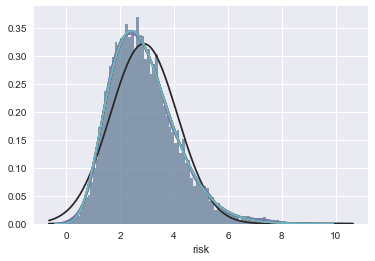

In [49]:
x = np.arange(-0.4,10,0.1)
y = pdf(x)
plt.plot(x,y)
plt.show()

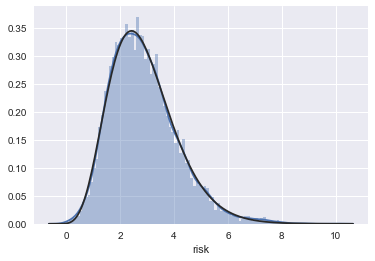

In [50]:
sns.distplot(risk_df["risk"],bins=100, fit=stats.gamma)
plt.show()

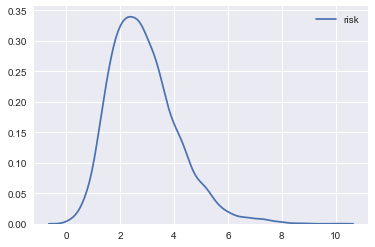

In [51]:
sns.kdeplot(risk_df["risk"])
plt.show()

In [52]:
n = len(risk_df["risk"])
h = n**(-1/5)
def k(x): return np.exp(- x**2 / (2*h**2) )/(n*np.sqrt(2* np.pi * h**2))
def pdf_k(x): return np.sum( k(x - risk_df["risk"]) )
#def pdf_k(x): return sum([ k(x - risk_df['risk'][j] ) for j in range(len(risk_df["risk"])) ])

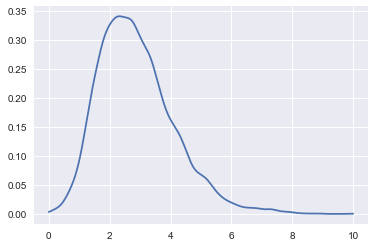

In [53]:
x = np.arange(0.,10,0.001)
y = np.array( [pdf_k(x[j]) for j in range(len(x))] )
plt.plot(x,y)
plt.show()

In [54]:
x = np.array(risk_df["risk"].sort_values())
y1 = pdf(x)
y2 = [pdf_k( x[j] ) for j in range(len(x))] 
y3 = stats.norm.pdf(x, 2.88, 1.24)

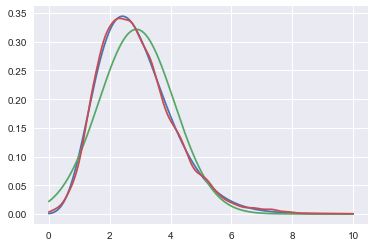

In [55]:
plt.plot(x,y1, x, y3, x, y2)
#plt.plot(x,y2)
#plt.plot(x,y3)
plt.show()

In [56]:
risk_stats_df = pd.DataFrame({"risk":x, "kde_fit":y2, "gaussian_fit":y3, "gamma_fit":y1})

In [57]:
risk_stats_df.to_sql('risk_stats',conn)

In [65]:
riskstats_df = pd.read_sql("SELECT * FROM risk_stats", conn)
riskstats_df.columns

Index(['index', 'gamma_fit', 'gaussian_fit', 'kde_fit', 'risk'], dtype='object')

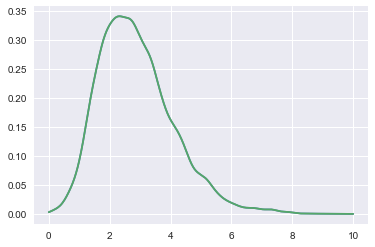

In [59]:
plt.plot(x,y2)
plt.show()

In [60]:
pd.Series(y2)

0       0.003355
1       0.005530
2       0.005697
3       0.006247
4       0.006963
5       0.007155
6       0.007386
7       0.007477
8       0.008309
9       0.008429
10      0.008924
11      0.008987
12      0.009524
13      0.010723
14      0.011386
15      0.012610
16      0.013340
17      0.013420
18      0.013922
19      0.014000
20      0.014329
21      0.014801
22      0.016413
23      0.018200
24      0.018803
25      0.019004
26      0.021701
27      0.021751
28      0.021814
29      0.021890
          ...   
6872    0.007864
6873    0.007852
6874    0.007817
6875    0.007804
6876    0.007339
6877    0.007051
6878    0.006990
6879    0.006818
6880    0.005897
6881    0.005694
6882    0.005380
6883    0.004605
6884    0.004472
6885    0.004324
6886    0.004135
6887    0.003964
6888    0.003949
6889    0.003807
6890    0.003802
6891    0.003546
6892    0.003505
6893    0.003168
6894    0.002871
6895    0.002100
6896    0.001226
6897    0.001100
6898    0.000814
6899    0.0008

In [61]:
np.array(risk_df["risk"].sort_values())

array([  0.        ,   0.09522548,   0.10197757, ...,   8.74323855,
         8.8537744 ,  10.        ])